In [1]:
# --- Imports ---
import os
import glob
import nilearn 
import pandas as pd
import numpy as np 
import nibabel as nib
from numpy import savetxt
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
from scipy.stats import gamma
from nilearn.glm.first_level import compute_regressor

from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting, image

analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'



## 2-Gammas

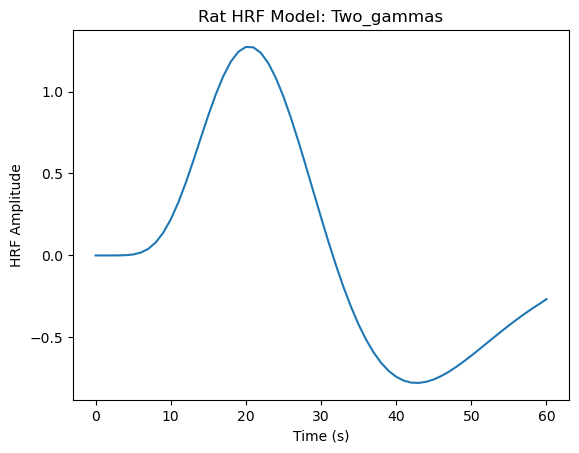

In [2]:
# --- Define Two_gammas --- 

"""
Implement the rat response function model

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Parameters gamma func
    ---------------------
    time_length : stimulation duration in seconds, must be defined before running the function
    tr : in seconds
    h1, h2, l1, and l2 : define the shape and scale parameters
    V = ratio parameter 
    
    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid

""" 

np.printoptions(False)

def Two_gammas(tr, oversampling=16, onset=0.0 ):
    dt = tr / oversampling
    #time_length = duration + onset
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset
     
    # Parameters of the gamma function
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5

    response_function = (gamma.pdf(time_stamps, h1 / l1, scale=1 / l1) -
                         gamma.pdf(time_stamps, h2 / l2, scale=1 / l2)) / V
    
    response_function /= response_function.sum()
    response_function *= 1
   
    return response_function


# --- Plot the function with example values ---

time_length = 30
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=Two_gammas,
                                    frame_times=frame_times)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF Model: Two_gammas')
plt.show()

## Peak-Span

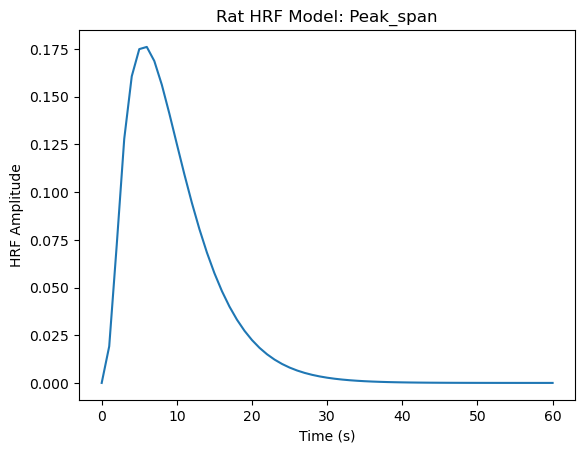

In [3]:
# --- Define Peak_span --- 

"""
Implement the rat response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid
"""

def Peak_span(tr, oversampling=16, onset=0.0):
    
    dt = tr / oversampling
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset

    # parameters of the gamma function
    delay = 2.18
    dispersion = 1.92

    response_function = gamma.pdf(time_stamps, delay, loc=0, scale=dispersion)
    response_function /= response_function.sum()

    return response_function


# --- Plot the function with example values ---

time_length = 30
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=Peak_span,
                                    frame_times=frame_times)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF Model: Peak_span')
plt.show()

## Design Matrix

In [4]:
# -- Define variables -- 

hrf_function=Peak_span  #Peak_span or Two_gammas
hrf_func='Peak_span'  #Peak_span or Two_gammas

n_stim = 6
onsets= 33, 123, 213, 303, 393, 483
durations= [6] * n_stim
tr = 1.5

trial_type = np.ones_like(onsets)
events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
print(events)

# -- Input data -- 
subj_num= 200201
# subject_path = glob.glob(analysis_folder + f"/sub-0{subj_num}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz")[0]
# subject_path='/project/4180000.19/multirat_stim/rabies/preprocess/sub-0200201_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0200201.session1_split_name_sub-0200201_ses-1_T2w/_run_1/sub-0200201_ses-1_run-1_bold_combined.nii.gz'

#func_img = nib.load(subject_path) 
#n_scans = func_img.shape[3]   
#frame_times = np.arange(n_scans) * tr 
#time_length = 6

   trial_type  onset  duration
0           1     33         6
1           1    123         6
2           1    213         6
3           1    303         6
4           1    393         6
5           1    483         6


### 1.	mc.nii.gz + peak.txt 

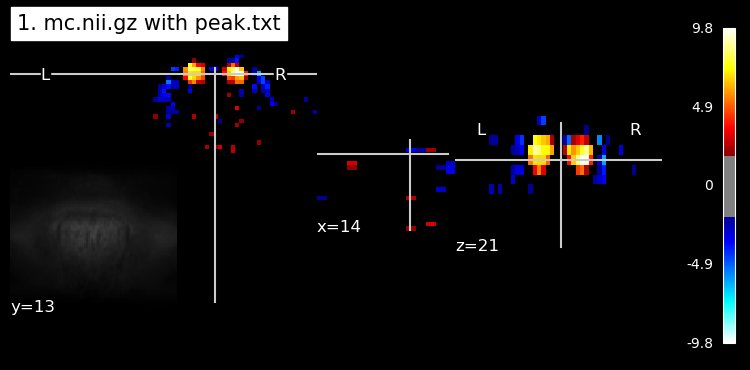

In [5]:
func_img= nib.load('/project/4180000.19/multirat_stim/tmp/mc.nii.gz')

# - Matrix - 
design_matrix =  pd.read_csv('/project/4180000.19/multirat_stim/tmp/peak.txt', sep=',')
#print(len(design_matrix))
#plot_design_matrix(design_matrix) 

# - Fit the GLM -
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(func_img, design_matrices=design_matrix)

# Compute the contrast
n_columns = design_matrix.shape[1]
contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))

statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')

plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                   bg_img = template_path, 
                                   cut_coords=(14, 13, 21), 
                                   threshold = 1.9, 
                                   title = '1. mc.nii.gz with peak.txt')


### 2.	mc.nii.gz + model built in nilearn

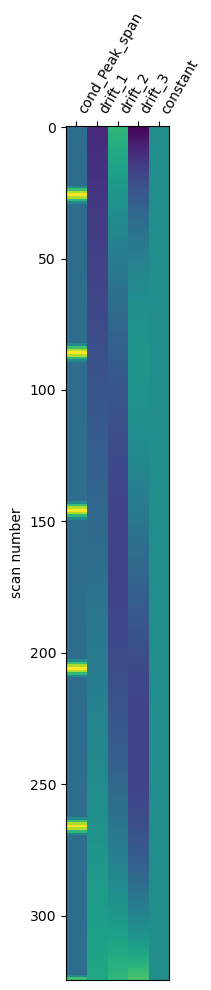

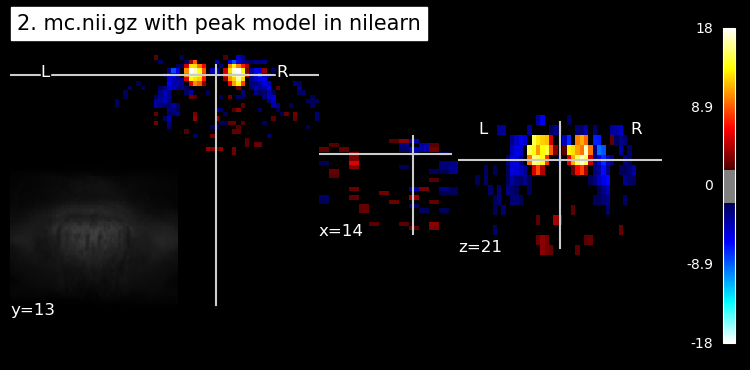

In [6]:
func_img= nib.load('/project/4180000.19/multirat_stim/tmp/mc.nii.gz')

# - Matrix - 
n_scans = func_img.shape[3]   
frame_times = np.arange(n_scans) * tr 
time_length = 6

exp_condition = np.array((onsets, durations, trial_type))
rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, hrf_function, frame_times)

design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                add_regs=rat_hrf_model,
                                                add_reg_names=_labels_hrf, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=None,  #or, glover, spm
                                                high_pass=0.01)

#savetxt(f'/project/4180000.19/multirat_stim/tmp//peak_nilearn-matrix.csv', design_matrix, delimiter=',')
design_matrix = design_matrix.iloc[:, 1:]
plot_design_matrix(design_matrix) 


# - Fit the GLM -
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(func_img, design_matrices=design_matrix)

# Compute the contrast
n_columns = design_matrix.shape[1]
contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))

statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')

plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                   bg_img = template_path, 
                                   cut_coords=(14, 13, 21), 
                                   threshold = 1.9, 
                                   title = '2. mc.nii.gz with peak model in nilearn')


### 3.	rabies output + peak.txt

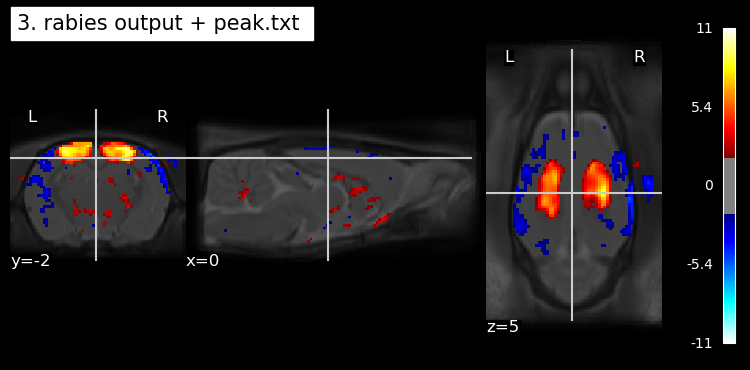

In [7]:
func_img= nib.load('/project/4180000.19/multirat_stim/rabies/preprocess/sub-0200201_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0200201.session1_split_name_sub-0200201_ses-1_T2w/_run_1/sub-0200201_ses-1_run-1_bold_combined.nii.gz')

# - Matrix - 
design_matrix =  pd.read_csv('/project/4180000.19/multirat_stim/tmp/peak.txt', sep=',')
  
#plot_design_matrix(design_matrix) 

# - Fit the GLM -
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(func_img, design_matrices=design_matrix)

# Compute the contrast
n_columns = design_matrix.shape[1]
contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))

statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')

plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                   bg_img = template_path, 
                                   #cut_coords=(14, 13, 21), 
                                   threshold = 1.9, 
                                   title = '3. rabies output + peak.txt ')


### 4.	rabies output + model built in nilearn

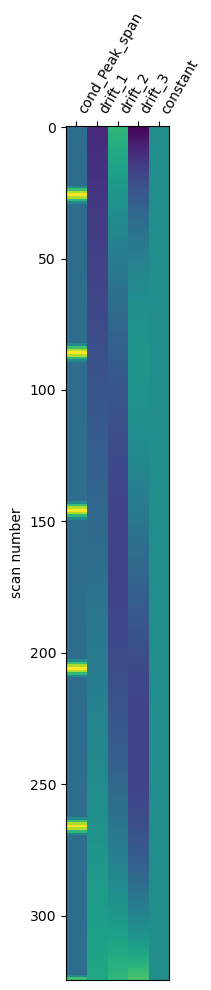

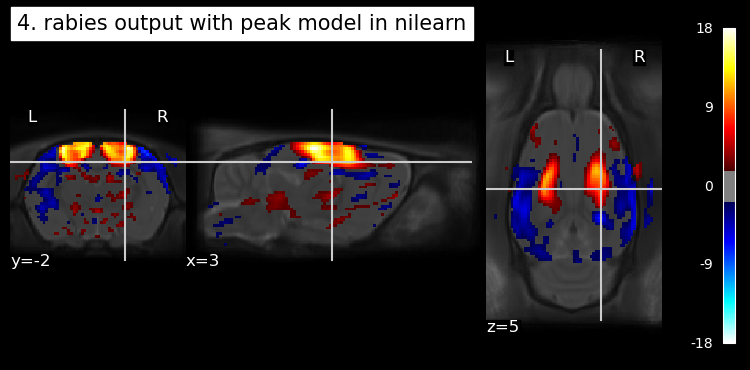

In [8]:
# --- Design Matrix For Rat HRF --- 

func_img= nib.load('/project/4180000.19/multirat_stim/rabies/preprocess/sub-0200201_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0200201.session1_split_name_sub-0200201_ses-1_T2w/_run_1/sub-0200201_ses-1_run-1_bold_combined.nii.gz')

# - Matrix - 

n_scans = func_img.shape[3]   
frame_times = np.arange(n_scans) * tr 
time_length = 6

exp_condition = np.array((onsets, durations, trial_type))
rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, hrf_function, frame_times)

design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                add_regs=rat_hrf_model,
                                                add_reg_names=_labels_hrf, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=None,  #or, glover, spm
                                                high_pass=0.01)


design_matrix = design_matrix.iloc[:, 1:]
plot_design_matrix(design_matrix) 

# - Fit the GLM -
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(func_img, design_matrices=design_matrix)

# Compute the contrast
n_columns = design_matrix.shape[1]
contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))

statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')

plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                   bg_img = template_path, 
                                   cut_coords=(3, -2, 5), 
                                   threshold = 1.9, 
                                   title = '4. rabies output with peak model in nilearn')

In [11]:
matrix_nilearn = pd.read_csv('/project/4180000.19/multirat_stim/tmp//peak_nilearn-matrix.csv')
peak_txt = pd.read_csv('/project/4180000.19/multirat_stim/tmp/peak.txt')

print(f"Length peak_nilearn : {len(matrix_nilearn.iloc[:,1])}")
print(f"Length of peak_txt : {len(peak_txt)}")
print(f"Length design_matrix : {len(design_matrix.iloc[:,1])}")

# Compare the two arrays
differences = np.setdiff1d(matrix_nilearn.iloc[:,1], matrix_nilearn.iloc[:,1])

print(f"Differences between peak_nilearn and peak_txt: {differences}")

Length peak_nilearn : 324
Length of peak_txt : 325
Length design_matrix : 325
Differences between peak_nilearn and peak_txt: []


In [12]:
# Plot the data from the three datasets
plt.figure(figsize=(14, 6))

# Assuming relevant data is in the second column for peak_nilearn and peak_matrix and first column for peak_txt
plt.plot(peak_nilearn.iloc[:,1], label='Peak_nilearn', color='blue')
plt.plot(peak_txt, label='Peak_txt', color='red')
plt.plot(design_matrix.iloc[:, 1], label='design_matrix', color='green')

plt.title('Comparison')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'peak_nilearn' is not defined

<Figure size 1400x600 with 0 Axes>

## Plot HRFs

(-1.5, 3.0)

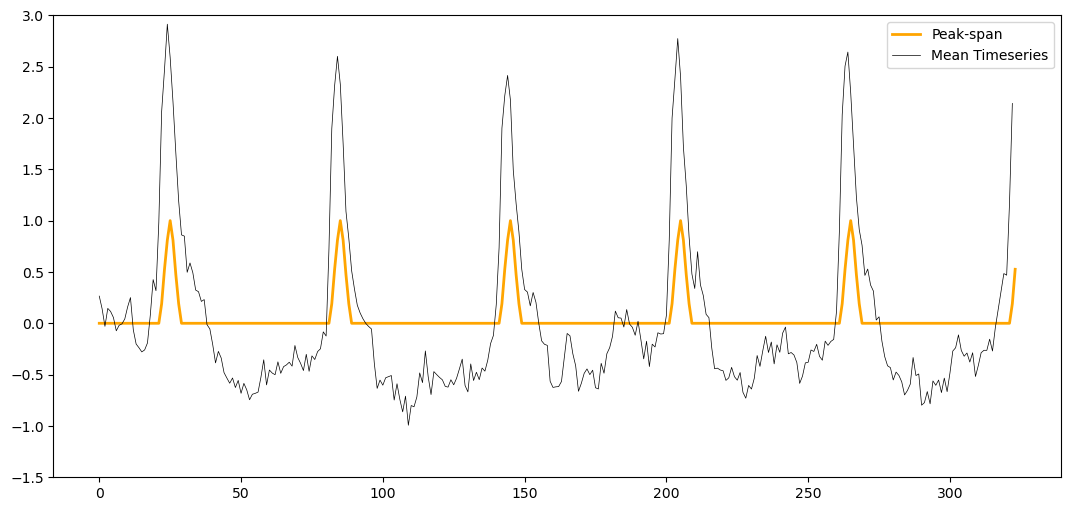

In [17]:
ds='02'
average_timeseries = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/mean_timeseries/mean-timeseries_ds-{ds}.csv')


#Two_gammas_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/Two_gammas-matrix_sub-020{ds}00.csv').iloc[:,1]
Peak_span_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/Peak_span-matrix_sub-020{ds}01.csv').iloc[:,1]
#glover_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/glover-matrix_sub-020{ds}00.csv').iloc[:,0]
spm_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/spm-matrix_sub-020{ds}01.csv').iloc[:,0]

plt.figure(figsize=(13, 6))

#plt.plot(Two_gammas_model, color='red', linewidth=2, label='Two_gammass')
plt.plot(Peak_span_model, color='orange', linewidth=2, label='Peak-span' )
#plt.plot(glover_model, color='blue', linewidth=1.5, label='Glover' )
#plt.plot(spm_model, color='green', linewidth=1.5, label='Spm' )
plt.plot(average_timeseries, color='black', linewidth=0.5, label='Mean Timeseries')

plt.legend()
plt.ylim(-1.5, 3)

## With motion confounds 

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.75048920e-05]
 [4.86809781e-03]
 [6.05126816e-02]
 [3.15511440e-01]
 [1.00000000e+00]
 [9.99952495e-01]
 [9.95131902e-01]
 [9.39487318e-01]
 [6.84488560e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.75048920e-05]
 [4.86809781e-03]
 [6.05126816e-02]
 [3.15511440e-01]
 [1.00000000e+00]
 [9.99952495e-01]
 [9.95131902e-01]
 [9.39487318e-01]
 [6.84488560e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

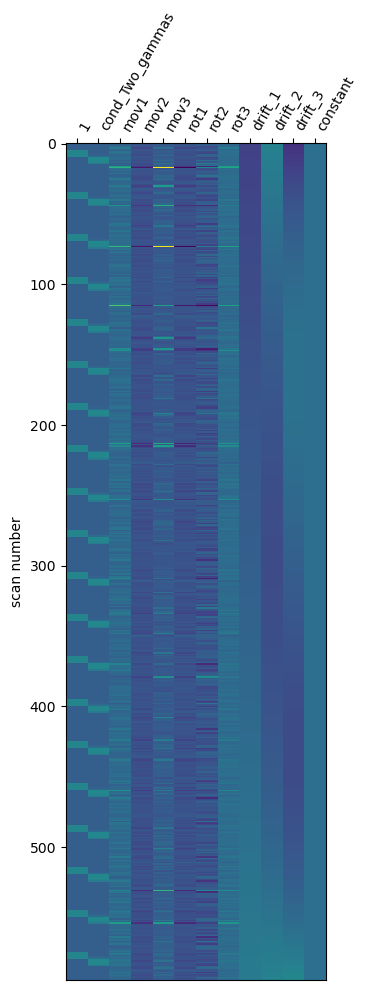

In [26]:
# --- Design Matrix For Rat HRF --- 

subj_num= 200300
ds= '03'
hrf_function=Two_gammas  #Peak_span or Two_gammas
hrf_func='Two_gammas'  #Peak_span or Two_gammas


# - HRF -
exp_condition = np.array((onsets, durations, trial_type))
rat_hrf_model, _labels_hrf = compute_regressor(exp_condition, hrf_function, frame_times)
print(rat_hrf_model)    

# --- Motion regressors ---

cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num))[0]

cofounders = pd.read_csv(cofounders_path, sep=',')

motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
motion = np.array(cofounders[motion_names])
    
all_regressors = np.column_stack((rat_hrf_model, motion))
all_reg_names = _labels_hrf + motion_names


design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                add_regs=all_regressors,
                                                add_reg_names=all_reg_names, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=None,  #or, glover, spm
                                                high_pass=0.01)
  
plot_design_matrix(design_matrix) 
savetxt(f'/project/4180000.19/multirat_stim/rabies/test_HRF/co-{hrf_func}-matrix_sub-0{subj_num}.csv', design_matrix, delimiter=',')


(-1.5, 3.0)

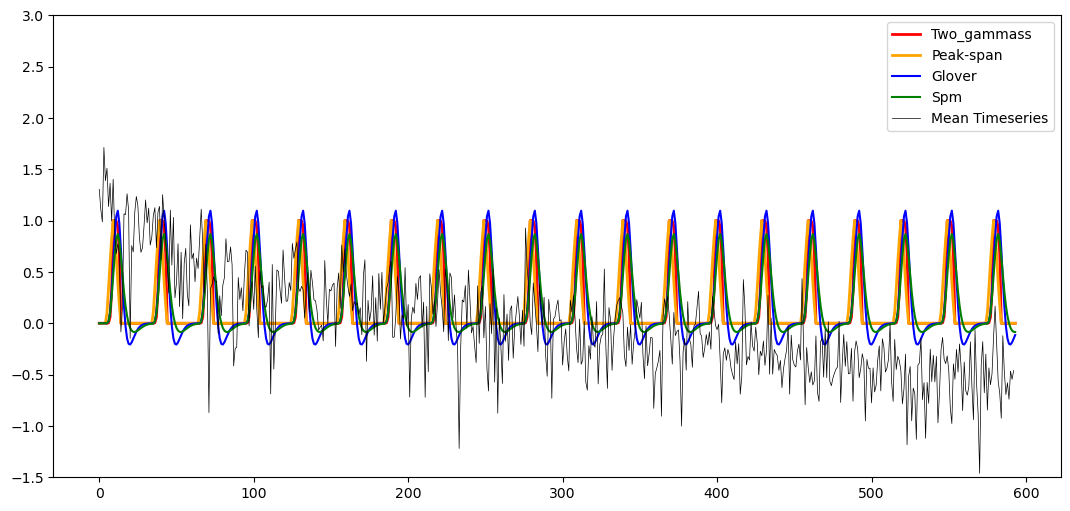

In [28]:
ds='03'
average_timeseries = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/mean_timeseries/mean-timeseries_ds-{ds}.csv')

Two_gammas_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/co-Two_gammas-matrix_sub-020{ds}00.csv').iloc[:,1]
Peak_span_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/co-Peak_span-matrix_sub-020{ds}00.csv').iloc[:,1]
glover_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/glover-matrix_sub-020{ds}00.csv').iloc[:,0]
spm_model = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/spm-matrix_sub-020{ds}00.csv').iloc[:,0]

plt.figure(figsize=(13, 6))

plt.plot(Two_gammas_model, color='red', linewidth=2, label='Two_gammass')
plt.plot(Peak_span_model, color='orange', linewidth=2, label='Peak-span' )
plt.plot(glover_model, color='blue', linewidth=1.5, label='Glover' )
plt.plot(spm_model, color='green', linewidth=1.5, label='Spm' )
plt.plot(average_timeseries, color='black', linewidth=0.5, label='Mean Timeseries')

plt.legend()
plt.ylim(-1.5, 3)

(-1.5, 3.0)

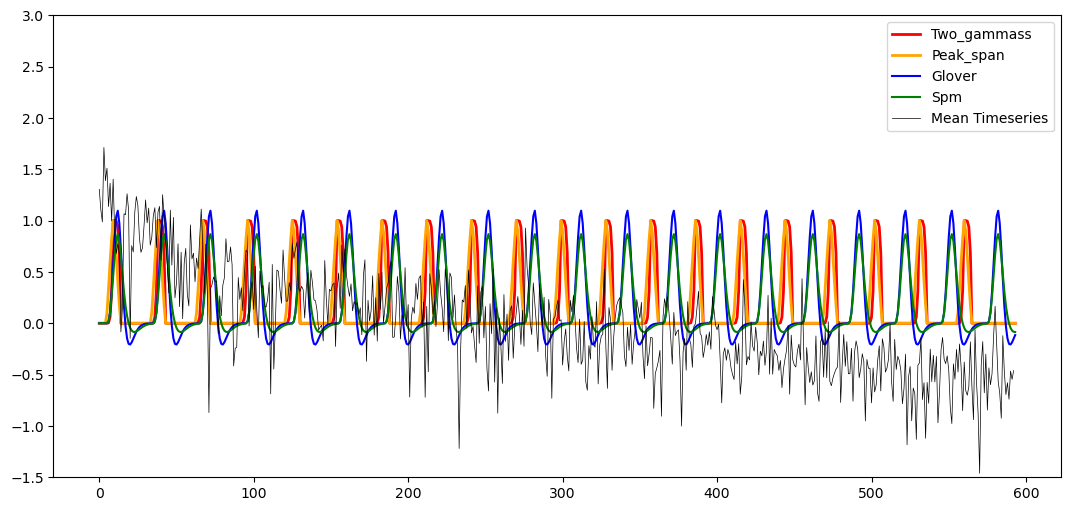

In [23]:
ds='03'
average_timeseries = pd.read_csv(f'/project/4180000.19/multirat_stim/rabies/test_HRF/mean_timeseries/mean-timeseries_ds-{ds}.csv')

Two_gammas_model = pd.read_csv(f'/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Two_gammas/matrix/matrix_sub-020{ds}00_ses-1.csv').iloc[:,0]
Peak_span_model = pd.read_csv(f'/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/Peak_span/matrix/matrix_sub-020{ds}00_ses-1.csv').iloc[:,0]
glover_model = pd.read_csv(f'/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/matrix/matrix_sub-020{ds}00_ses-1.csv').iloc[:,0]
spm_model = pd.read_csv(f'/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/matrix/matrix_sub-020{ds}00_ses-1.csv').iloc[:,0]

plt.figure(figsize=(13, 6))

plt.plot(Two_gammas_model, color='red', linewidth=2, label='Two_gammass')
plt.plot(Peak_span_model, color='orange', linewidth=2, label='Peak_span' )
plt.plot(glover_model, color='blue', linewidth=1.5, label='Glover' )
plt.plot(spm_model, color='green', linewidth=1.5, label='Spm' )
plt.plot(average_timeseries, color='black', linewidth=0.5, label='Mean Timeseries')

plt.legend()
plt.ylim(-1.5, 3)

In [ ]:
hrf_model = 'spm' # glover or spm

# --- Design Matrix For Rat HRF --- 
design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                events=events, 
                                                drift_model="polynomial", 
                                                drift_order=3, 
                                                hrf_model=hrf_model,  
                                                high_pass=0.01)
    
plot_design_matrix(design_matrix) 
print(f'Number of time points in Peak_00: {len(design_matrix.iloc[:,1])}')
savetxt(f'/project/4180000.19/multirat_stim/rabies/test_HRF/{hrf_model}-matrix_sub-0{subj_num}.csv', design_matrix, delimiter=',')